In [1]:
import sys
import pandas as pd
import os
import datetime
import json

In [2]:
impr_dir = '/home/keyi/mta/impression/'
click_dir = '/home/keyi/mta/click/'
act_dir = '/home/keyi/mta/activity/'
match_table_dir = '/home/keyi/mta/match_tables/'

In [3]:
ADVERTISER_ID = 9395210
FLOODLIGHT_CONFIG = 9395210

In [4]:
click = pd.read_csv('./files/clicks_20190616_2019-07-22.csv', dtype=str)
impression = pd.read_csv('./files/impressions_20190616_2019-07-22.csv', dtype=str)
activity = pd.read_csv('./files/activity_20190615_2019-07-22.csv', dtype=str)
with open('./files/user_groups.json', 'r') as f:
    users = json.load(f)
    buyer = users['buyer']
    high_value = users['high_value']
    low_value = users['low_value']
    media_only = users['media_only']
    

In [5]:
def read_mapping_from_date(prefix, date):
    matched = [i for i in os.listdir(match_table_dir) if (i.startswith(prefix) and i>=(prefix+date))]
    mapping_df = pd.concat([pd.read_csv(match_table_dir+f, dtype=str) for f in matched])
    mapping_df.drop_duplicates(inplace=True)
    return mapping_df
    

In [6]:
site_mapping = read_mapping_from_date('dcm_account7252_match_table_sites_', '20190701')

dma_mapping = read_mapping_from_date('dcm_account7252_match_table_designated_market_areas_', '20190701')

os_mapping = read_mapping_from_date('dcm_account7252_match_table_operating_systems_', '20190701')

campaign_mapping = read_mapping_from_date('dcm_account7252_match_table_campaigns_', '20190701')

placement_mapping = read_mapping_from_date('dcm_account7252_match_table_placements_', '20190701')



In [10]:
len(click), len(impression)

(44333, 2191119)

In [8]:
# filter only checking exposures

checking_campaigns = ['3668 - Umpqua Bank - Always on Checking', 'DART Search']
remove_placement = 'Umpqua - Deposits - EST3664'

checking_campaign_ids = set(campaign_mapping[campaign_mapping['Campaign'].isin(checking_campaigns)]['Campaign ID'].astype(str))
remove_placement_id = set(placement_mapping[placement_mapping['Placement']==remove_placement]['Placement ID'].astype(str))

click = click[click['Campaign ID'].isin(checking_campaign_ids)]
click = click[~click['Placement ID'].isin(remove_placement_id)]

impression = impression[impression['Campaign ID'].isin(checking_campaign_ids)]
impression = impression[~impression['Placement ID'].isin(remove_placement_id)]


In [9]:
len(click), len(impression)

(44333, 2191119)

In [11]:
def which_group(s):
    if s in buyer:
        return 'buyer'
    elif s in high_value:
        return 'high_value'
    elif s in low_value:
        return 'low_value'
    else:
        return 'media_only'

In [12]:
def get_effectiveness_index(_users):
    '''
    Args:
        users: pd.Series, value is set of str (User ID)
    Returns:
        pd.DataFrame
    '''
    _buyer = _users.apply(lambda x: len(x.intersection(buyer)))
    _high = _users.apply(lambda x: len(x.intersection(high_value)))
    _low = _users.apply(lambda x: len(x.intersection(low_value)))
    _no = _users.apply(lambda x: len(x.intersection(media_only)))

    index = (_buyer + _high) / (_low + _no)

    sum_index = (_buyer.sum() + _high.sum()) / (_low.sum() + _no.sum())

    return pd.DataFrame({
        'total_ids': _users.apply(len),
        'buyer_ids': _buyer,
        'high_value_ids': _high,
        'low_value_ids': _low,
        'media_only_ids': _no,
        'index': index / sum_index}
    )[['total_ids', 'buyer_ids', 'high_value_ids', 'low_value_ids', 'media_only_ids', 'index']]


In [13]:
start_date = '20190615'
end_date = '20190723'

In [19]:
impression_files = [f for f in impression_files if f>=('dcm_account7252_impression_'+start_date) and f<('dcm_account7252_impression_'+end_date)]
click_files = [f for f in click_files if f>=('dcm_account7252_click_'+start_date) and f<('dcm_account7252_click_'+end_date)]
activity_files = [f for f in activity_files if f>=('dcm_account7252_activity_'+start_date) and f<('dcm_account7252_activity_'+end_date)]





## load impression files

In [12]:
impression_files = os.listdir(impr_dir)
click_files = os.listdir(click_dir)
activity_files = os.listdir(act_dir)


In [ ]:
def read_impr_file(f):
    impr_df = pd.read_csv(
        impr_dir+f,
        usecols=['Event Time', 'User ID', 'Advertiser ID', 'Campaign ID', 
             'Operating System ID', 'Rendering ID',
             'Placement ID', 'Site ID (DCM)',
             'Designated Market Area (DMA) ID'],
        dtype={'Event Time': int,
           'User ID': str,
           'Advertiser ID': int,
           'Campaign ID': int,
           'Site ID (DCM)': int,
           'Operating System ID': int,
           'Rendering ID': int,
           'Placement ID': int}
    )
    impr_df = impr_df[impr_df['Advertiser ID']==ADVERTISER_ID]
    impr_df['Event Time'] = impr_df['Event Time']//1000000
    impr_df['date'] = impr_df['Event Time'].apply(
        lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    impr_df.reset_index(inplace=True, drop=True)
    del impr_df['Advertiser ID'], impr_df['Event Time']
    return impr_df

In [ ]:
impressions = []
for f in impression_files:
    impr_df = read_impr_file(f)
    impressions.append(impr_df)
    

In [ ]:
impressions = pd.concat(impressions, ignore_index=True)
impressions.to_csv('./files/impressions_%s_%s.csv'%(start_date,str(datetime.datetime.today().date())), index=False)



In [ ]:
set(impressions['date'])

In [ ]:
min(impression_files)

In [ ]:
impr_user = set(impressions['User ID'])

In [ ]:
len(impr_user)

## load click files

In [ ]:
def read_click_file(f):
    click_df = pd.read_csv(
        click_dir+f,
        usecols=['Event Time', 'User ID', 'Advertiser ID', 'Campaign ID', 
             'Operating System ID', 'Rendering ID',
             'Placement ID', 'Site ID (DCM)',
             'Designated Market Area (DMA) ID', 'Segment Value 1'],
        dtype={'Event Time': int,
               'User ID': str,
               'Advertiser ID': int,
               'Campaign ID': int,
               'Site ID (DCM)': int,
               'Operating System ID': int,
               'Rendering ID': int,
               'Placement ID': int,
               'Segment Value 1': str
        }
    )
    click_df = click_df[click_df['Advertiser ID']==ADVERTISER_ID]
    click_df['Event Time'] = click_df['Event Time']//1000000
    click_df['date'] = click_df['Event Time'].apply(
        lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    click_df.reset_index(inplace=True, drop=True)
    del click_df['Advertiser ID'], click_df['Event Time']
    return click_df

In [ ]:
min(click_files), max(click_files)

In [ ]:
clicks = []
for f in click_files:
    click_df = read_click_file(f)
    clicks.append(click_df)

In [ ]:
clicks = pd.concat(clicks, ignore_index=True)
clicks.to_csv('./files/clicks_%s_%s.csv'%(start_date,str(datetime.datetime.today().date())), index=False)


In [ ]:
click_user = set(clicks['User ID'])
len(click_user)

In [ ]:
exposure_user = impr_user.union(click_user)

## load activity files

In [21]:
def read_act_file(f):
    df = pd.read_csv(
        act_dir+f, 
        usecols=['Event Time', 'User ID', 'Activity ID', 'Floodlight Configuration'],
        dtype={'Event Time': int,
               'User ID': str,
               'Activity ID': int,
               'Floodlight Configuration': int
              })
    df = df[df['Floodlight Configuration']==FLOODLIGHT_CONFIG]
    df['Event Time'] = df['Event Time']//1000000
    df['date'] = df['Event Time'].apply(
        lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    df.reset_index(inplace=True, drop=True)
    del df['Floodlight Configuration']
    return df

In [22]:
activity = []
for f in activity_files:
    act_df = read_act_file(f)
    activity.append(act_df)

In [23]:
activity = pd.concat(activity, ignore_index=True)
activity.to_csv('./files/activity_%s_%s.csv'%(start_date,'2019-07-22'), index=False)


In [ ]:
act_user = set(activity['User ID'])

In [ ]:
len(act_user)

In [52]:
act_df = pd.read_csv('/home/keyi/mta/activity/dcm_account7252_activity_20190722_20190723_060924_2600347603.csv.gz', nrows=10)


In [55]:
set(act_df['Campaign ID']), set(act_df['Placement ID'])

({nan, nan, nan, nan, nan, nan, nan, 20836313.0},
 {nan, nan, nan, nan, nan, nan, nan, 215909526.0, 215929001.0})

In [60]:
placements[placements['Placement ID']=='215929001']

,Campaign ID,Site ID (DCM),Placement ID,Site Keyname,Placement,Content Category,Placement Strategy,Placement Start Date,Placement End Date,Placement Group Type,Package/Roadblock ID,Placement Cost Structure,Placement Cap Cost Option,Activity ID,Flighting Activated
146485,20836313,1234535,215929001,N7252.128246.1331159373351/B20836313.215929001,Google - Big Lots - Search,NaN,NaN,20180302,20230227,NaN,0,CPM,Cumulative,0,FALSE


## User Conditions

In [8]:
def get_act_mapping(day_range=7):
    start = (datetime.datetime.today()-datetime.timedelta(days=day_range)).strftime('%Y%m%d')
    match_tables = [f for f in os.listdir(match_table_dir) if f.startswith('dcm_account7252_match_table_activity_cats_') and f>'dcm_account7252_match_table_activity_cats_'+start]
    all_df = []
    for f in match_tables:
        df = pd.read_csv(match_table_dir+f)
        df = df[df['Floodlight Configuration']==FLOODLIGHT_CONFIG]
        all_df.append(df)
    all_df = pd.concat(all_df, ignore_index=True)
    all_df.drop_duplicates('Activity ID', inplace=True)
    return all_df

In [9]:
act_mapping = get_act_mapping()

In [10]:
buyer_condition = ['Step 10 - FL - Open Account - Complete - 10 - MS']
buyer_condition = list(act_mapping[act_mapping['Activity'].isin(buyer_condition)]['Activity ID'])
buyer_condition


[8577021]

In [13]:
high_value_condition = [
 'FL - Personal_Online Mobile_Download Personal Mobile Banking App_ IOS - MS',
 'FL - Personal_Online Mobile_Download Personal Mobile Banking App_ Android - MS',
 'FL - Personal_Loans and Lines_Contact us_Submit - MS',
 'Step 4 - FL - Open Account - Primary App pg 2 - 04 - MS',
 'Step 4a - FL - Open Account - Joint App pg 2 - 04a - MS',
 'Step 5 - FL - Open Account - Account Options - 05 - MS',
 'Step 6 - FL - Open Account - Security - 06 - MS',
 'Step 7 - FL - Open Account - Applicant Review - 07 - MS',
 'Step 8 - FL - Open Account - Disclosure - 08 - MS',
 'Step 8a - FL - Open Account - Fund Account - 08a - MS',
 'Step 9 - FL - Open Account - Initial Deposit - 09 - MS',
]
len(high_value_condition)


11

In [14]:
high_value_condition = list(act_mapping[act_mapping['Activity'].isin(high_value_condition)]['Activity ID'])
len(high_value_condition)


11

## User Group

In [4]:
click = pd.read_csv('./files/clicks_20190616_2019-07-22.csv')
impression = pd.read_csv('./files/impressions_20190616_2019-07-22.csv')
activity = pd.read_csv('./files/activity_20190615_2019-07-22.csv')

In [5]:
exposure_users = set(click['User ID']).union(set(impression['User ID']))

In [6]:
activity_users = set(activity['User ID'])

In [15]:
buyers = set(activity[activity['Activity ID'].isin(buyer_condition)]['User ID']).intersection(exposure_users)
len(buyers)

107

In [16]:
high_values_1 = set(activity[activity['Activity ID'].isin(high_value_condition)]['User ID']).intersection(exposure_users)
len(high_values_1)

452

In [17]:
media_only = exposure_users.difference(activity_users)

In [19]:
user_with_value = exposure_users.intersection(activity_users)
len(user_with_value), len(media_only)

(25961, 353220)

In [20]:
len(exposure_users), len(media_only), len(user_with_value), len(high_values_1), len(buyers)

(379181, 353220, 25961, 452, 107)

In [32]:
activity_value = activity[activity['User ID'].isin(user_with_value)]
activity_value = activity_value[activity_value['User ID']!='0']
activity_value = activity_value[~activity_value['User ID'].isin(buyers)]
len(activity_value)

601350

In [33]:
multi_session_filter = [
    'Step 1 - FL - Open Account - Get Started - 01 - MS',
    'Step 2 - FL - Open Account - Ownership - 02 - MS',
    'Step 3 - FL - Open Account - Primary App pg 1 - 03 - MS',
    'Step 3a - FL - Open Account - Joint App pg 1 - 03a - MS'
]

In [34]:
multi_session_filter = list(act_mapping[act_mapping['Activity'].isin(multi_session_filter)]['Activity ID'])
len(multi_session_filter)

4

In [35]:
high_values_2 = set()
multi_session_visitor = set()
count = 0
for user, group in activity_value.groupby('User ID'):
    group = group.sort_values(by='Event Time')
    group.reset_index(inplace=True, drop=True)
    session_start = 0
    if group.loc[max(group.index),'Event Time']-group.loc[0,'Event Time']>1800:
        user_activity = set(group['Activity ID'])
        multi_session_visitor = multi_session_visitor.union(set([user]))
        if len(user_activity.intersection(multi_session_filter))!=0:
            if len(user_activity.intersection(high_value_condition))==0:
                count = count+1
                continue
        high_values_2 = high_values_2.union(set([user]))
len(high_values_2)

13103

In [36]:
len(high_values_2), len(multi_session_visitor), count

(13103, 13317, 214)

In [42]:
high_value = high_values_1.union(high_values_2).difference(buyers).difference(media_only)

In [44]:
low_value = user_with_value.difference(high_value).difference(buyers)


In [45]:
len(high_value), len(low_value)

(13297, 12557)

In [24]:
high_values = high_values_2.union(high_values_1).difference(buyers)

In [25]:
len(high_values_2.intersection(high_values_1).difference(buyers))

7325

In [26]:
low_values = user_with_value.difference(high_values).difference(buyers)

In [50]:
len(media_only), len(low_value), len(high_value), len(buyers)

(353220, 12557, 13297, 107)

In [47]:
users = {
    'media_only': list(media_only),
    'low_value': list(low_value),
    'high_value': list(high_value),
    'buyer': list(buyers)
}

In [48]:
import json
with open('./files/user_groups.json', 'w') as f:
    json.dump(users, f)

## keyword cost

In [13]:
keyword_cost = pd.read_csv(
    './files/cost_by_kw_by_date_20190615_20190721.csv', dtype=str)
kw_id = pd.read_csv('./files/kw_id_20190615_20190721.csv', dtype=str)


In [14]:

keyword_cost['Clicks'] = keyword_cost['Clicks'].astype(int)
keyword_cost['Cost'] = keyword_cost['Cost'].astype(float)

kw_cpc = keyword_cost.groupby(['Keyword', 'date'], as_index=False)[['Cost', 'Clicks']].sum()

kw_cpc['cpc'] = (kw_cpc['Cost'] / kw_cpc['Clicks']).fillna(0)

len(kw_cpc[kw_cpc['Cost']!=0]), len(kw_cpc)

(2631, 125356)

In [26]:
kw_click = click.merge(kw_id[['Segment Value 1', 'Keyword']], on='Segment Value 1', how='left')
kw_click = kw_click[kw_click['Keyword'].notnull()].reset_index(drop=True)

kw_click['cpc'] = kw_click.merge(kw_cpc, on=['Keyword', 'date'], how='left')['cpc']
kw_click.head(2)

,User ID,Campaign ID,Rendering ID,Site ID (DCM),Placement ID,Operating System ID,Designated Market Area (DMA) ID,Segment Value 1,date,Keyword,cpc
0,AMsySZY_MNvcxjbTIi5YXmpDupjP,22770254,0,1234535,247812694,501012,209.0,45086769618,2019-06-22,umpqua bank,0.978916
1,AMsySZY60YbZzZovU_gixu6c091_,22770254,0,1234535,247812694,501013,197.0,45086775468,2019-06-22,umpqua bank,0.978916


In [28]:
len(kw_click[kw_click['cpc'].isnull()]), len(kw_click)

(0, 42926)

In [29]:
kw_click['type'] = kw_click['Keyword'].apply(
    lambda x: 'brand' if 'umpqua' in x.lower() else 'non-brand')

In [30]:
kw_click[kw_click['Site ID (DCM)']=='1292147']

,User ID,Campaign ID,Rendering ID,Site ID (DCM),Placement ID,Operating System ID,Designated Market Area (DMA) ID,Segment Value 1,date,Keyword,cpc,type


In [31]:
kw_click['site'] = kw_click.merge(site_mapping, on='Site ID (DCM)', how='left')['Site (DCM)']
site_rename = {
    'DART Search : Google': 'Google',
    'DART Search : Bing': 'Bing',
    'missing': None
}
kw_click['site'] = kw_click['site'].fillna('missing').apply(lambda x: site_rename[x])
kw_click['site'] = kw_click['site']+'_'+kw_click['type']



In [34]:
kw_click['group'] = kw_click['User ID'].apply(which_group)

In [35]:
brand_kw = kw_click[kw_click['site']=='Google_brand']
nonbrand_kw = kw_click[kw_click['site']=='Google_non-brand']

In [36]:
user_by_kw = brand_kw.groupby('Keyword')['User ID'].apply(set)

df_kw = get_effectiveness_index(user_by_kw)

cost_by_kw = brand_kw.groupby(['Keyword', 'group'])['cpc'].sum()

cost_by_kw_by_group = cost_by_kw.unstack().fillna(0)

res_df = df_kw.join(cost_by_kw_by_group).sort_values('index', ascending=False)
res_df.to_csv('./files/google_brand_cost_by_keyword_0807.csv')


In [37]:
user_by_kw = nonbrand_kw.groupby('Keyword')['User ID'].apply(set)

df_kw = get_effectiveness_index(user_by_kw)

cost_by_kw = nonbrand_kw.groupby(['Keyword', 'group'])['cpc'].sum()

cost_by_kw_by_group = cost_by_kw.unstack().fillna(0)
res_df = df_kw.join(cost_by_kw_by_group).sort_values('index', ascending=False)
res_df.to_csv('./files/google_nonbrand_cost_by_keyword_0807.csv')


## device performance

In [38]:
    os_to_device = {
        '(not set)': '(not set)',
        'Android': 'mobile',
        'Apple iOS': 'mobile',
        'BlackBerry': 'mobile',
        'DoCoMo': 'mobile',
        'Linux': 'desktop',
        'Macintosh': 'desktop',
        'Microsoft Windows 10': 'desktop',
        'Microsoft Windows 2000': 'desktop',
        'Microsoft Windows 7': 'desktop',
        'Microsoft Windows 8': 'desktop',
        'Microsoft Windows 95': 'desktop',
        'Microsoft Windows 98': 'desktop',
        'Microsoft Windows NT': 'desktop',
        'Microsoft Windows Unknown Version': 'desktop',
        'Microsoft Windows Vista': 'desktop',
        'Microsoft Windows XP': 'desktop',
        'Nokia Maemo': 'mobile',
        'Nokia Series 60': 'mobile',
        'NokiaSeries60': 'mobile',
        'Other': 'other',
        'Other/Unknown': 'Other/Unknown',
        'PS4': 'desktop',
        'PSP': 'desktop',
        'Palm OS': 'mobile',
        'Palm webOS': 'mobile',
        'PalmWebOS': 'mobile',
        'Playstation3': 'desktop',
        'Playstation4': 'desktop',
        'Roku': 'desktop',
        'Samsung Bada': 'mobile',
        'Unix': 'desktop',
        'Unix, Linux': 'desktop',
        'Unix, unknown': 'desktop',
        'Wii': 'desktop',
        'Wii U': 'desktop',
        'WiiU': 'desktop',
        'Windows 2000': 'desktop',
        'Windows 7': 'desktop',
        'Windows 98': 'desktop',
        'Windows Mobile': 'mobile',
        'Windows NT': 'desktop',
        'Windows Phone': 'mobile',
        'Windows Phone 7+': 'mobile',
        'Windows Vista': 'desktop',
        'Windows XP': 'desktop',
        'Windows, version unknown': 'desktop',
        'Windows10': 'desktop',
        'Windows8': 'desktop',
        'WindowsPhone': 'mobile',
        'Xbox 360': 'desktop',
        'Xbox One': 'desktop',
        'Xbox360': 'desktop',
        'XboxOne': 'desktop',
        'iOS': 'mobile',
    }

In [39]:
exposure_df = click.append(impression, ignore_index=True)


/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [40]:
exposure_df = exposure_df.merge(site_mapping[['Site ID (DCM)','Site (DCM)']], on='Site ID (DCM)', how='left')
exposure_df = exposure_df.merge(os_mapping, on='Operating System ID', how='left')
exposure_df.head(1)


,Campaign ID,Designated Market Area (DMA) ID,Operating System ID,Placement ID,Rendering ID,Segment Value 1,Site ID (DCM),User ID,date,Site (DCM),Operating System
0,22770254,209.0,501012,247812694,0,45086769618,1234535,AMsySZY_MNvcxjbTIi5YXmpDupjP,2019-06-22,DART Search : Google,Apple iOS


In [41]:
len(exposure_df), len(exposure_df[exposure_df['Operating System'].isnull()])

(2235452, 489399)

In [42]:
exposure_df['device'] = exposure_df['Operating System'].fillna('(not set)').apply(lambda x: os_to_device[x])


In [43]:
with pd.ExcelWriter('./files/device_performance_0807.xlsx') as writer:
    for site, df_exposure_one_site in exposure_df.groupby('Site (DCM)'): 
        user_by_device = df_exposure_one_site.groupby('device')['User ID'].apply(set)
        effectiveness_index_by_device = get_effectiveness_index(user_by_device)
        effectiveness_index_by_device.to_excel(writer, sheet_name=site.replace(':','_'))
    user_by_device = exposure_df.groupby('device')['User ID'].apply(set)
    effectiveness_index_by_device = get_effectiveness_index(user_by_device)
    effectiveness_index_by_device.to_excel(writer, sheet_name='all sites')
    writer.save()


## DMA Performance

In [44]:
exposure_df = click.append(impression, ignore_index=True)
exposure_df = exposure_df.merge(site_mapping[['Site ID (DCM)','Site (DCM)']], on='Site ID (DCM)', how='left')
exposure_df['Designated Market Area (DMA) ID'] = exposure_df['Designated Market Area (DMA) ID'].fillna(0).apply(lambda x: str(int(float(x))))
exposure_df = exposure_df.merge(dma_mapping, on='Designated Market Area (DMA) ID', how='left')
exposure_df['Designated Market Area (DMA)'].fillna('(not set)', inplace=True)


In [45]:
with pd.ExcelWriter('./files/dma_performance_0807.xlsx') as writer:
    for site, df_exposure_one_site in exposure_df.groupby('Site (DCM)'): 
        user_by_dma = df_exposure_one_site.groupby('Designated Market Area (DMA)')['User ID'].apply(set)
        effectiveness_index_by_dma = get_effectiveness_index(user_by_dma)
        effectiveness_index_by_dma.to_excel(writer, sheet_name=site.replace(':','_'))
    user_by_dma = exposure_df.groupby('Designated Market Area (DMA)')['User ID'].apply(set)
    effectiveness_index_by_dma = get_effectiveness_index(user_by_dma)
    effectiveness_index_by_dma.to_excel(writer, sheet_name='all sites')
    writer.save()


## Placement Performance

In [46]:
exposure_df = click.append(impression, ignore_index=True)
exposure_df = exposure_df.merge(site_mapping[['Site ID (DCM)','Site (DCM)']], on='Site ID (DCM)', how='left')
exposure_df['Placement ID'] = exposure_df['Placement ID'].fillna(0).apply(lambda x: str(int(float(x))))
exposure_df['Placement'] = exposure_df.merge(placement_mapping, on='Placement ID', how='left')['Placement']
exposure_df['Placement'].fillna('(not set)', inplace=True)


In [47]:
with pd.ExcelWriter('./files/placement_performance.xlsx') as writer:
    for site, df_exposure_one_site in exposure_df.groupby('Site (DCM)'): 
        user_by_dma = df_exposure_one_site.groupby('Placement')['User ID'].apply(set)
        effectiveness_index_by_dma = get_effectiveness_index(user_by_dma)
        effectiveness_index_by_dma.to_excel(writer, sheet_name=site.replace(':','_'))
    user_by_dma = exposure_df.groupby('Placement')['User ID'].apply(set)
    effectiveness_index_by_dma = get_effectiveness_index(user_by_dma)
    effectiveness_index_by_dma.to_excel(writer, sheet_name='all sites')
    writer.save()
    

## Creative Performance

In [48]:
creatives = pd.read_csv(
    '/home/keyi/mta/match_tables/dcm_account7252_match_table_creatives_20190722_20190723_033334_2600347398.csv.gz',
    dtype=str
)


In [49]:
exposure_df = click.append(impression, ignore_index=True)
exposure_df = exposure_df.merge(site_mapping[['Site ID (DCM)','Site (DCM)']], on='Site ID (DCM)', how='left')
exposure_df['Rendering ID'] = exposure_df['Rendering ID'].fillna(0).apply(lambda x: str(int(float(x))))
exposure_df['Creative'] = exposure_df.merge(creatives, on='Rendering ID', how='left')['Creative']
exposure_df['Creative'].fillna('(not set)', inplace=True)


In [50]:
with pd.ExcelWriter('./files/creative_performance_0807.xlsx') as writer:
    for site, df_exposure_one_site in exposure_df.groupby('Site (DCM)'): 
        user_by_dma = df_exposure_one_site.groupby('Creative')['User ID'].apply(set)
        effectiveness_index_by_dma = get_effectiveness_index(user_by_dma)
        effectiveness_index_by_dma.to_excel(writer, sheet_name=site.replace(':','_'))
    user_by_dma = exposure_df.groupby('Creative')['User ID'].apply(set)
    effectiveness_index_by_dma = get_effectiveness_index(user_by_dma)
    effectiveness_index_by_dma.to_excel(writer, sheet_name='all sites')
    writer.save()
    

## First exposure to 1st act

In [35]:
exposure_df = click.append(impression, ignore_index=True)
exposure_df = exposure_df[exposure_df['User ID']!='0']
first_exposure = exposure_df.sort_values(by='date', ascending=True)
first_exposure = first_exposure.drop_duplicates('User ID', keep='first')
first_exposure.rename(columns={
    'date': 'exposure_date'
}, inplace=True)
first_exposure.head(3)

,Campaign ID,Designated Market Area (DMA) ID,Operating System ID,Placement ID,Rendering ID,Segment Value 1,Site ID (DCM),User ID,exposure_date
24194,22770254,210.0,501032,247812694,0,44720982785,1234535,AMsySZbSNL6a2xIBOSk38KOSwrUD,2019-06-15
18966,22770254,197.0,501032,247812694,0,44721009908,1234535,AMsySZYV2M5hGmRAhcqDU5gO-zbS,2019-06-15
9826,22770254,202.0,501013,247812694,0,44721240754,1234535,AMsySZYEcAd3Dpms22pSaZehfxMz,2019-06-15


In [36]:
first_exposure.reset_index(drop=True, inplace=True)

In [37]:
activity = activity[activity['User ID']!='0']
first_act = activity.sort_values(by='date', ascending=True)
first_act = first_act.drop_duplicates('User ID', keep='first')
first_act.rename(columns={
    'date': 'act_date'
}, inplace=True)
first_act.head(3)


,Event Time,User ID,Activity ID,act_date
2531077,1560571945,AMsySZZOl_ZOJgpelgHtt-vEdSTK,8550254,2019-06-15
2520572,1560583183,AMsySZZvbeOEmuMDfqg-hZ2J3j67,8559342,2019-06-15
2520573,1560612206,AMsySZZhtzH0JSc-673xYZmgr9E-,8550254,2019-06-15


In [38]:
first_act.reset_index(drop=True, inplace=True)

In [43]:
exposure_to_act = first_exposure[['User ID', 'exposure_date', 'Site ID (DCM)']].merge(first_act[['User ID', 'act_date']], on='User ID', how='left')
exposure_to_act = exposure_to_act[exposure_to_act['act_date'].notnull()]


In [44]:
exposure_to_act['exposure_date'] = exposure_to_act['exposure_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
exposure_to_act['act_date'] = exposure_to_act['act_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))


In [45]:
exposure_to_act['day'] = exposure_to_act['act_date']-exposure_to_act['exposure_date']

In [48]:

exposure_to_act = exposure_to_act.merge(site_mapping[['Site ID (DCM)','Site (DCM)']], on='Site ID (DCM)', how='left')


In [49]:
with pd.ExcelWriter('./files/first_exposure_to_first_act_0807.xlsx') as writer:
    for site, df_one_site in exposure_to_act.groupby('Site (DCM)'): 
        user_by_day = df_one_site.groupby('day')['User ID'].apply(set)
        effectiveness_index_by_day = get_effectiveness_index(user_by_day)
        effectiveness_index_by_day.to_excel(writer, sheet_name=site.replace(':','_'))
    user_by_day = exposure_to_act.groupby('day')['User ID'].apply(set)
    effectiveness_index_by_day = get_effectiveness_index(user_by_day)
    effectiveness_index_by_day.to_excel(writer, sheet_name='all sites')
    writer.save()

In [ ]:
## user path

## User Cluster

In [11]:
click['type'] = 'click'
impression['type'] = 'impression'
kw_id = pd.read_csv('./files/kw_id_20190615_20190721.csv', dtype=str)
click['Keyword'] = click.merge(kw_id, on='Segment Value 1', how='left')['Keyword']
click['Keyword'].fillna('', inplace=True)
click['kw_type'] = click['Keyword'].apply(
    lambda x: '(brand)' if 'umpqua' in x.lower() else '(non-brand)')



In [12]:
exposure_df = click.append(impression, ignore_index=True)
exposure_df = exposure_df.merge(site_mapping[['Site ID (DCM)','Site (DCM)']], on='Site ID (DCM)', how='left')
exposure_df['kw_type'].fillna('', inplace=True)
exposure_df['site'] = exposure_df['Site (DCM)']+'_'+exposure_df['type']+exposure_df['kw_type']


/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [15]:
exposure_df['Campaign'] = exposure_df.merge(campaign, on='Campaign ID', how='left')['Campaign']
exposure_df['Placement'] = exposure_df.merge(placements, on='Placement ID', how='left')['Placement']

exposure_df.head()


,Campaign ID,Designated Market Area (DMA) ID,Keyword,Operating System ID,Placement ID,Rendering ID,Segment Value 1,Site ID (DCM),User ID,date,kw_type,type,Site (DCM),site,Campaign,Placement
0,22770254,209.0,umpqua bank,501012,247812694,0,45086769618,1234535,AMsySZY_MNvcxjbTIi5YXmpDupjP,2019-06-22,(brand),click,DART Search : Google,DART Search : Google_click(brand),DART Search,Umpqua - Checking - EST3651
1,22770254,197.0,umpqua bank,501013,247812694,0,45086775468,1234535,AMsySZY60YbZzZovU_gixu6c091_,2019-06-22,(brand),click,DART Search : Google,DART Search : Google_click(brand),DART Search,Umpqua - Checking - EST3651
2,22770254,211.0,+checking +online,501012,247812694,0,45086904661,1234535,AMsySZaFu5d8trOgheux1w2HDcx2,2019-06-22,(non-brand),click,DART Search : Google,DART Search : Google_click(non-brand),DART Search,Umpqua - Checking - EST3651
3,22770254,202.0,+umpqua +bank,501013,247812694,0,45086764797,1234535,AMsySZZmC7Qt9Q0rdhN0b1KqJCaN,2019-06-22,(brand),click,DART Search : Google,DART Search : Google_click(brand),DART Search,Umpqua - Checking - EST3651
4,22770254,201.0,+umpqua +account,501032,247812694,0,45086764803,1234535,AMsySZZjzCi84Otw5NEkfd7X_iXZ,2019-06-22,(brand),click,DART Search : Google,DART Search : Google_click(brand),DART Search,Umpqua - Checking - EST3651


In [16]:
checking_campaigns = ['3668 - Umpqua Bank - Always on Checking', 'DART Search']
remove_placement = 'Umpqua - Deposits - EST3664'

exposure_df_filtered = exposure_df[exposure_df['Campaign'].isin(checking_campaigns)]
exposure_df_filtered = exposure_df_filtered[exposure_df_filtered['Placement']!=remove_placement]



In [20]:
len(exposure_df_filtered[exposure_df_filtered['site']=='The Trade Desk_click(non-brand)']), len(exposure_df_filtered[exposure_df_filtered['site']=='The Trade Desk_impression'])


(221, 55533)

In [21]:
len(exposure_df_filtered[exposure_df_filtered['site']=='Google_click(non-brand)']), len(exposure_df_filtered[exposure_df_filtered['site']=='Google_impression'])


(1186, 2135586)

In [22]:
def google_site_split(row):
    if row['site'].startswith('Google'):
        if 'prospecting' in row['Placement'].lower():
            return 'Google_prospecting_'+row['type']
        elif 'retargeting' in row['Placement'].lower():
            return 'Google_retargeting_'+row['type']
    return row['site']

In [23]:
exposure_df_filtered['filtered_site'] = exposure_df_filtered.apply(google_site_split, axis=1)


In [25]:
exposure_df_grouped = exposure_df_filtered.groupby(['User ID', 'filtered_site']).apply(len)


In [26]:
exposure_user_by_visit = exposure_df_grouped.unstack().fillna(0)
exposure_user_by_visit.reset_index(inplace=True)
exposure_user_by_visit.columns

Index(['User ID', 'DART Search : Google_click(brand)',
       'DART Search : Google_click(non-brand)', 'Google_prospecting_click',
       'Google_prospecting_impression', 'Google_retargeting_click',
       'Google_retargeting_impression', 'The Trade Desk_click(non-brand)',
       'The Trade Desk_impression'],
      dtype='object', name='filtered_site')

In [27]:
res_sites=[
    'Google_prospecting_click', 
    'Google_retargeting_impression', 
    'Google_prospecting_impression', 
    'Google_retargeting_click', 
    'DART Search : Google_click(non-brand)', 
    'DART Search : Google_click(brand)', 
    'The Trade Desk_impression', 
    'The Trade Desk_click'
]

In [28]:
#exposure_user_by_visit.columns = ['User ID', 'DART Search : Google_click(brand)', 'DART Search : Google_click(non-brand)', 'Google_click(non-brand)', 'Google_impression', 'The Trade Desk_click(non-brand)', 'The Trade Desk_impression']
#exposure_user_by_visit['Google'] = exposure_user_by_visit['Google_impression']+exposure_user_by_visit['Google_click(non-brand)']
exposure_user_by_visit['The Trade Desk_click'] = exposure_user_by_visit['The Trade Desk_click(non-brand)']
exposure_user_by_visit = exposure_user_by_visit[['User ID']+res_sites]

In [30]:
exposure_user_by_visit = exposure_user_by_visit[exposure_user_by_visit['User ID']!='0']
max_vals = {}
for col in exposure_user_by_visit.columns[1:]:
    exposure_user_by_visit[col] = exposure_user_by_visit[col].astype(int)
    max_val = max(exposure_user_by_visit[col])
    exposure_user_by_visit[col] = exposure_user_by_visit[col]*1000/max_val
    max_vals[col] = max_val

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
max_vals

{'Google_prospecting_click': 5,
 'Google_retargeting_impression': 3668,
 'Google_prospecting_impression': 2101,
 'Google_retargeting_click': 3,
 'DART Search : Google_click(non-brand)': 169,
 'DART Search : Google_click(brand)': 94,
 'The Trade Desk_impression': 20,
 'The Trade Desk_click': 2}

In [32]:
exposure_user_by_visit.head(3)

filtered_site,User ID,Google_prospecting_click,Google_retargeting_impression,Google_prospecting_impression,Google_retargeting_click,DART Search : Google_click(non-brand),DART Search : Google_click(brand),The Trade Desk_impression,The Trade Desk_click
1,AMsySZY--2KPdE4QioWg8MSJIw4O,0.0,0.0,0.000000,0.0,0.0,0.0,100.0,0.0
2,AMsySZY--5F7nDOnfk_vvDrHQ718,0.0,0.0,0.951928,0.0,0.0,0.0,0.0,0.0
3,AMsySZY--CFTxPzgE01YO0xaMSf_,0.0,0.0,0.475964,0.0,0.0,0.0,0.0,0.0


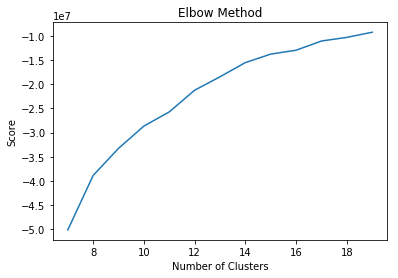

CPU times: user 8min 15s, sys: 19min 19s, total: 27min 34s
Wall time: 3min 57s


In [41]:
%%time

number_clusters = range(7, 20)

kmeans = [KMeans(n_clusters=i, max_iter=50) for i in number_clusters]

score = [kmeans[i].fit(visit_freq).score(visit_freq) for i in range(len(kmeans))]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [33]:
from sklearn.cluster import KMeans

In [34]:
%%time
visit_freq = exposure_user_by_visit[res_sites].values

kmeans = KMeans(n_clusters=20, random_state=0).fit(visit_freq)


CPU times: user 47.2 s, sys: 3min 11s, total: 3min 58s
Wall time: 1min 41s


In [35]:
exposure_user_by_visit['cluster'] = kmeans.labels_
for n, group in exposure_user_by_visit.groupby('cluster'):
    print(n, len(group))

0 241430
1 1205
2 170
3 627
4 246
5 118
6 285
7 2126
8 987
9 5291
10 876
11 607
12 17843
13 4508
14 2510
15 27
16 36
17 60
18 14
19 52


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
less_than_30 = [15, 18]
exposure_user_by_visit_df = exposure_user_by_visit[~exposure_user_by_visit['cluster'].isin(less_than_30)]
kmean_visit_freq = exposure_user_by_visit_df[res_sites].values
kmeans_label = exposure_user_by_visit_df[['cluster']].values


In [39]:
for col in res_sites:
    exposure_user_by_visit_df[col] = exposure_user_by_visit_df[col]*max_vals[col]/1000
exposure_user_by_visit_df
    
    

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


filtered_site,User ID,Google_prospecting_click,Google_retargeting_impression,Google_prospecting_impression,Google_retargeting_click,DART Search : Google_click(non-brand),DART Search : Google_click(brand),The Trade Desk_impression,The Trade Desk_click,cluster
1,AMsySZY--2KPdE4QioWg8MSJIw4O,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,7
2,AMsySZY--5F7nDOnfk_vvDrHQ718,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0
3,AMsySZY--CFTxPzgE01YO0xaMSf_,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,AMsySZY--E6cPFrPTQEYyLlWoYkW,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
5,AMsySZY--Ik839o5UFTyoaJHF8B4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
6,AMsySZY--KlevCt6FBaSb0m2EQwE,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0
7,AMsySZY--KunQu94o_VAjYt96TV4,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0
8,AMsySZY--LojloJBT5U-gSEVDCDg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
9,AMsySZY--UqG2Z4TDra50GGRAL2v,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0
10,AMsySZY--X09xXuF6uveubVbneli,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0


In [41]:
user_by_cluster = exposure_user_by_visit_df.groupby('cluster')['User ID'].apply(set) 
effectiveness_index_by_cluster = get_effectiveness_index(user_by_cluster)


In [42]:
site_visit_by_cluster = exposure_user_by_visit_df.groupby('cluster')[res_sites].apply(sum)
res_cluster_20 = site_visit_by_cluster.join(effectiveness_index_by_cluster)


In [43]:
res_cluster_20

,Google_prospecting_click,Google_retargeting_impression,Google_prospecting_impression,Google_retargeting_click,DART Search : Google_click(non-brand),DART Search : Google_click(brand),The Trade Desk_impression,The Trade Desk_click,total_ids,buyer_ids,high_value_ids,low_value_ids,media_only_ids,index
cluster,,,,,,,,,,,,,,
0,0.0,94671.0,705824.0,0.0,6478.0,0.0,0.0,0.0,241430,12,2565,4956,233897,0.284879
1,0.0,0.0,0.0,0.0,0.0,0.0,5302.0,0.0,1205,0,0,6,1199,0.000000
2,1.0,1.0,16.0,0.0,0.0,0.0,75.0,173.0,170,0,3,16,151,0.474331
3,627.0,5496.0,3663.0,0.0,0.0,0.0,0.0,0.0,627,0,1,230,396,0.042180
4,0.0,0.0,140346.0,0.0,0.0,0.0,0.0,0.0,246,0,2,1,243,0.216430
5,9.0,8079.0,285.0,118.0,13.0,46.0,0.0,0.0,118,0,50,56,12,19.415015
6,0.0,0.0,0.0,0.0,0.0,0.0,3042.0,1.0,285,0,0,2,283,0.000000
7,0.0,0.0,7.0,0.0,0.0,0.0,4252.0,0.0,2126,0,0,5,2121,0.000000
8,0.0,0.0,224044.0,0.0,0.0,2.0,0.0,0.0,987,0,7,3,977,0.188603


In [44]:
visit_freq = exposure_user_by_visit[res_sites].values

kmeans_14 = KMeans(n_clusters=14, random_state=0).fit(visit_freq)
exposure_user_by_visit['cluster'] = kmeans_14.labels_
for n, group in exposure_user_by_visit.groupby('cluster'):
    print(n, len(group))


0 261705
1 1233
2 3233
3 687
4 170
5 374
6 133
7 410
8 846
9 2743
10 40
11 5291
12 2126
13 27


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [45]:
less_than_30 = [13]
exposure_user_by_visit_df = exposure_user_by_visit[~exposure_user_by_visit['cluster'].isin(less_than_30)]
kmean_visit_freq = exposure_user_by_visit_df[res_sites].values
kmeans_label = exposure_user_by_visit_df[['cluster']].values
for col in res_sites:
    exposure_user_by_visit_df[col] = exposure_user_by_visit_df[col]*max_vals[col]/1000
exposure_user_by_visit_df


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


filtered_site,User ID,Google_prospecting_click,Google_retargeting_impression,Google_prospecting_impression,Google_retargeting_click,DART Search : Google_click(non-brand),DART Search : Google_click(brand),The Trade Desk_impression,The Trade Desk_click,cluster
1,AMsySZY--2KPdE4QioWg8MSJIw4O,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,12
2,AMsySZY--5F7nDOnfk_vvDrHQ718,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0
3,AMsySZY--CFTxPzgE01YO0xaMSf_,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,AMsySZY--E6cPFrPTQEYyLlWoYkW,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
5,AMsySZY--Ik839o5UFTyoaJHF8B4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
6,AMsySZY--KlevCt6FBaSb0m2EQwE,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0
7,AMsySZY--KunQu94o_VAjYt96TV4,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0
8,AMsySZY--LojloJBT5U-gSEVDCDg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
9,AMsySZY--UqG2Z4TDra50GGRAL2v,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0
10,AMsySZY--X09xXuF6uveubVbneli,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0


In [46]:
user_by_cluster = exposure_user_by_visit_df.groupby('cluster')['User ID'].apply(set) 
effectiveness_index_by_cluster = get_effectiveness_index(user_by_cluster)
site_visit_by_cluster = exposure_user_by_visit_df.groupby('cluster')[res_sites].apply(sum)
res_cluster_14 = site_visit_by_cluster.join(effectiveness_index_by_cluster)
res_cluster_14

,Google_prospecting_click,Google_retargeting_impression,Google_prospecting_impression,Google_retargeting_click,DART Search : Google_click(non-brand),DART Search : Google_click(brand),The Trade Desk_impression,The Trade Desk_click,total_ids,buyer_ids,high_value_ids,low_value_ids,media_only_ids,index
cluster,,,,,,,,,,,,,,
0,0.0,126944.0,836284.0,0.0,6625.0,24653.0,0.0,0.0,261705,67,9308,10262,242068,0.980774
1,0.0,0.0,1.0,0.0,0.0,0.0,7100.0,0.0,1233,0,0,5,1228,0.000000
2,0.0,0.0,13.0,0.0,0.0,0.0,10422.0,0.0,3233,0,1,11,3221,0.008168
3,755.0,5628.0,4662.0,1.0,0.0,0.0,0.0,0.0,687,0,3,238,446,0.115779
4,1.0,1.0,16.0,0.0,0.0,0.0,75.0,173.0,170,0,3,16,151,0.474211
5,0.0,0.0,182983.0,0.0,0.0,1.0,0.0,0.0,374,0,4,2,368,0.285381
6,11.0,10627.0,301.0,152.0,13.0,86.0,0.0,0.0,133,0,54,65,14,18.044012
7,0.0,0.0,0.0,0.0,0.0,0.0,4042.0,1.0,410,0,0,2,408,0.000000
8,0.0,3456.0,11.0,0.0,43.0,9544.0,0.0,0.0,846,2,722,10,112,156.655332


In [47]:
visit_freq = exposure_user_by_visit[res_sites].values

kmeans_10 = KMeans(n_clusters=10, random_state=0).fit(visit_freq)
exposure_user_by_visit['cluster'] = kmeans_10.labels_
for n, group in exposure_user_by_visit.groupby('cluster'):
    print(n, len(group))


0 264587
1 3233
2 285
3 170
4 688
5 1358
6 619
7 134
8 527
9 7417


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [48]:
less_than_30 = []
exposure_user_by_visit_df = exposure_user_by_visit[~exposure_user_by_visit['cluster'].isin(less_than_30)]
kmean_visit_freq = exposure_user_by_visit_df[res_sites].values
kmeans_label = exposure_user_by_visit_df[['cluster']].values
for col in exposure_user_by_visit_df.columns[1:-1]:
    exposure_user_by_visit_df[col] = exposure_user_by_visit_df[col]*max_vals[col]/1000
user_by_cluster = exposure_user_by_visit_df.groupby('cluster')['User ID'].apply(set) 
effectiveness_index_by_cluster = get_effectiveness_index(user_by_cluster)
site_visit_by_cluster = exposure_user_by_visit_df.groupby('cluster')[res_sites].apply(sum)
res_cluster_10 = site_visit_by_cluster.join(effectiveness_index_by_cluster)
res_cluster_10


,Google_prospecting_click,Google_retargeting_impression,Google_prospecting_impression,Google_retargeting_click,DART Search : Google_click(non-brand),DART Search : Google_click(brand),The Trade Desk_impression,The Trade Desk_click,total_ids,buyer_ids,high_value_ids,low_value_ids,media_only_ids,index
cluster,,,,,,,,,,,,,,
0,0.0,171283.0,1145856.0,0.0,6629.0,26701.0,0.0,0.0,264587,67,9597,10287,244636,0.999500
1,0.0,0.0,13.0,0.0,0.0,0.0,10422.0,0.0,3233,0,1,11,3221,0.008158
2,0.0,0.0,0.0,0.0,0.0,0.0,3042.0,1.0,285,0,0,2,283,0.000000
3,1.0,1.0,16.0,0.0,0.0,0.0,75.0,173.0,170,0,3,16,151,0.473631
4,756.0,7022.0,4753.0,1.0,0.0,0.0,0.0,0.0,688,0,3,239,446,0.115469
5,0.0,0.0,1.0,0.0,0.0,0.0,8100.0,0.0,1358,0,0,5,1353,0.000000
6,0.0,0.0,294376.0,0.0,0.0,1.0,0.0,0.0,619,0,6,2,611,0.258063
7,11.0,13991.0,301.0,154.0,13.0,90.0,0.0,0.0,134,0,55,65,14,18.355684
8,0.0,1262.0,11.0,0.0,39.0,7499.0,0.0,0.0,527,2,461,4,60,190.737461


In [49]:
with pd.ExcelWriter('./files/user_cluster_filtered_0807.xlsx') as writer:
    res_cluster_20.to_excel(writer, sheet_name='cluster=20')
    res_cluster_14.to_excel(writer, sheet_name='cluster=14')
    res_cluster_10.to_excel(writer, sheet_name='cluster=10')
    writer.save()